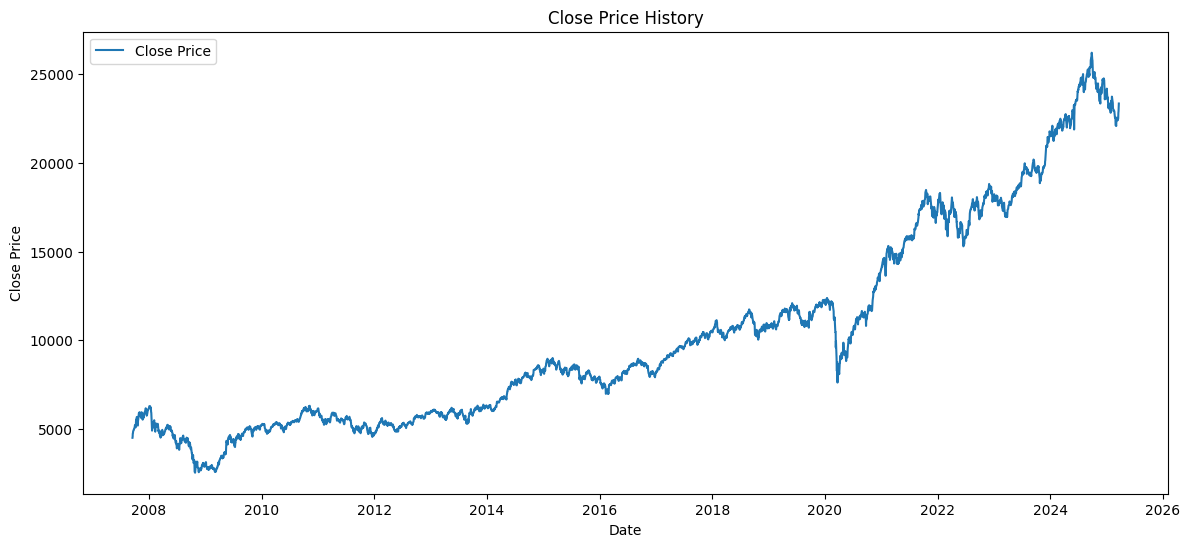

In [6]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Load the data
import pandas as pd

# Read data from CSV file
df = pd.read_csv('indices/NIFTY_50.csv', skiprows=2,
                 names=['Date', 'Close', 'High', 'Low', 'Open', 'Volume'])

# Remove rows where 'Date' column mistakenly contains the string 'Date'
df = df[df['Date'] != 'Date']

# Convert 'Date' to datetime format and handle errors explicitly
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Drop rows with invalid dates
df.dropna(subset=['Date'], inplace=True)

# Sort by Date, set as index, and drop any remaining NaN values
df.sort_values('Date', inplace=True)
df.set_index('Date', inplace=True)
df.dropna(inplace=True)

# Optional: Reorder columns to standard format
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
# Visualize the data
plt.figure(figsize=(14, 6))
plt.plot(df['Close'], label='Close Price')
plt.title('Close Price History')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [7]:
# Data preprocessing
def preprocess_lstm_data(df, column='Close', time_step=60):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df[[column]])

    X, y = [], []
    for i in range(time_step, len(scaled_data)):
        X.append(scaled_data[i-time_step:i, 0])
        y.append(scaled_data[i, 0])
    return np.array(X), np.array(y), scaler

time_step = 60
X, y, scaler = preprocess_lstm_data(df)

# Split into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape the data
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:

# Build the stacked LSTM model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, return_sequences=False),
    
    Dense(50, activation='relu'),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=32, epochs=20, verbose=1)


Epoch 1/20


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step
RMSE: 88.12815646872606
MAE: 68.2852527196079
MAPE: 1.9706819980462809
R^2 Score: 0.9656313546187495


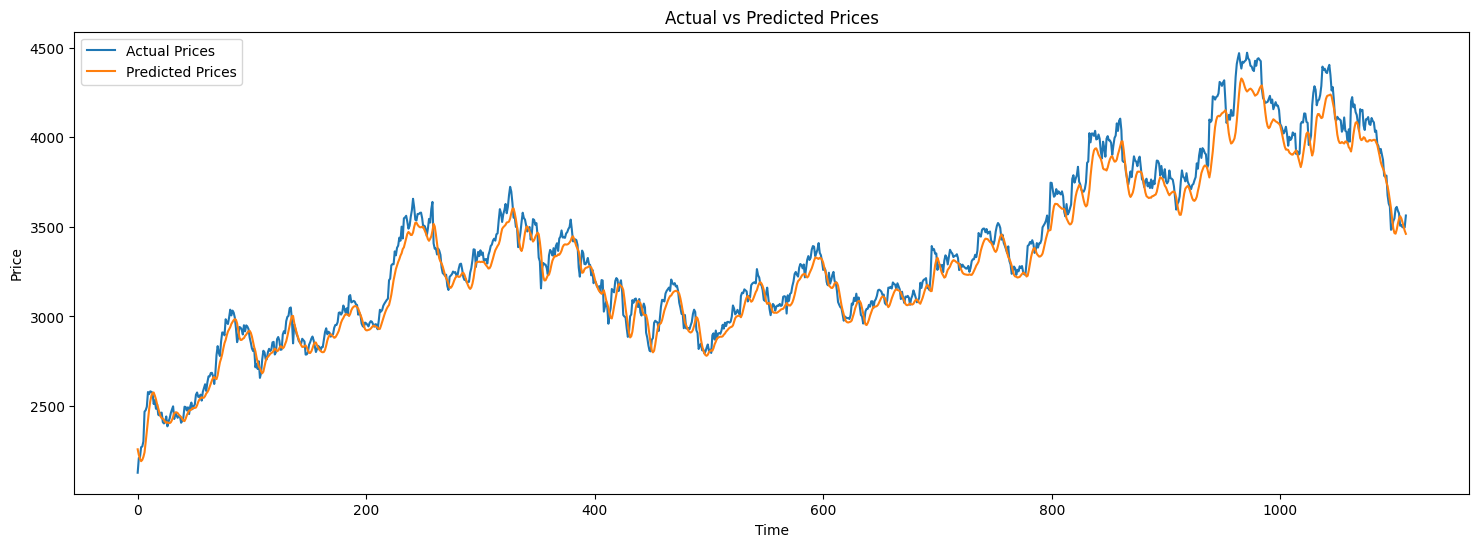

In [ ]:
# Make predictions
y_pred = model.predict(X_test)

# Reverse scaling for both y_test and y_pred
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_rescaled = scaler.inverse_transform(y_pred)

# Evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
mape = np.mean(np.abs((y_test_rescaled - y_pred_rescaled) / y_test_rescaled)) * 100
r2 = r2_score(y_test_rescaled, y_pred_rescaled)


print("RMSE:", rmse)
print("MAE:", mae)
print("MAPE:", mape)
print("R^2 Score:", r2)

# Plotting predictions vs actual
plt.figure(figsize=(18, 6))
plt.plot(y_test_rescaled, label='Actual Prices')
plt.plot(y_pred_rescaled, label='Predicted Prices')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


In [ ]:
# Save the trained model
model.save('stacked_lstm_model.keras')
